<a href="https://colab.research.google.com/github/georgejordan3/IBM_Capstone/blob/main/Bicycle_Cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bicycle Cities - Evaluating the Best Cities in the US to Ride a Bicycle

George Jordan <br>
IBM Data Science Professional Certificate Capstone <br>
Last Updated: 3-4-21

<img src="https://www.confluence-denver.com/galleries/Features/2016/Issue_164/bike_lanes_04.jpg">

Credit: [Confluence Denver](https://www.confluence-denver.com/features/denver_bike_lanes_082416.aspx)


[Medium](https://georgejordan3.medium.com/bicycle-cities-evaluating-the-best-cities-in-the-us-to-ride-a-bicycle-30daaedb8e99)

## Introduction 
I am a competitive cyclist and moving to Denver was partially motivated by my love for cycling. While I have a strong understanding of the riding experience here, I wonder how my experience compares to other cyclists in various parts of the US. I hope to tell a detailed story of these cities through the eyes of a cyclist and through the lens of data.

In this project, I will examine a list of the highest ranking bicycle cities in the country and apply my own analysis to gain further insight into the cities and their unique characteristics. I will use analytic tools as well as machine learning algorithms to see how these cities relate to each other and also gain insight into other supporting factors that have made these cities accessible via bicycle.

While this project is personally interesting to me, I believe that the insights here could be useful for a variety of business applications. Perhaps there is a company in one of these cities that is considering including provisions to support bike commuters. Maybe the existence of bicycle infrastructure is important to a company and an investigation into potential locations for an office would require such an analysis to foster that kind of culture in the workplace.

I believe that the bicycle is a very powerful tool to not only navigate a city but to also change it, through culture and infrastructure. I hope this project illuminates some of the impact that the bicycle has had on these cities.

## Data 
### PlacesForBikes City Ratings
- [PlacesForBikes City Ratings](https://cityratings.peopleforbikes.org/)

For this project, I will be first looking at the PlacesForBikes ratings to see their list of top cities for bicycles. They have made their data available for the public as well as an explanation to their methodology in ranking. It is from this data that I will select a number of cities to examine further, while also studying their decisions in ranking.

### Foursquare
- [Foursquare](https://foursquare.com/)

I will be using the Foursquare API to get an understanding of the selected cities from the rankings above. Using the Geocoder library, I will find venues close to the top-ranked cities in the City Ratings and see if there are any patterns. Then, I will use regression analysis to see if there is any relationship between the categories of these venues and the ranking they have received as a top city for bicycles.

## Methodology 


### Using City Ranking

In [2]:
import pandas as pd
import folium
import requests
import numpy as np
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim

For the City Ratings, I saved the files locally and then uploaded the files into the notebook.

In [3]:
# If I was using a file from some other hosting source, using !wget command would be apporpriate, but it seemed to be a waste of time to host the file online just to demonstrate the ability to upload a file.
pfbr = pd.read_excel("pfbr.xls")

With the data uploaded, getting an idea of the scope of the dataset is an important way to start structuring our analysis.

In [4]:
pfbr.shape

(567, 55)

We'll just be looking at the top ten cities.



In [5]:
top_cities = pfbr.head(10)
top_cities

,Places_ID_2020,City,City_Alt,ACS Bike-to-Work Mode Share,Land Area,Population,ACS Target,ACS Normalized Score,ACS Ridership Points,SMS Recreation Riding,SMS Points,Community Survey Ridership Score,Total Ridership Points,Average Fatalities All Mode,All Mode Fatality Rate,All Mode Fatality Points,Average Fatalities Bike,Bike Fatality Rate,Bike Fatality Points,All Mode Injuries,All Mode Injury Rate,All Mode Injury Points,Bike Injuries,Bike Injury Rate,Bike Injury Points,All mode safety points,Bike Safety Points,Community Survey Safety Score,Total Safety Points,City Snapshot Points,Community Survey Acceleration Score,Total Acceleration Points,BNA,BNA Points,Community Survey Network Score,Total Network Points,Percent Communities of Concern,Number Underserved Communities,Average BNA,BNA Underserved Communities,BNA Gap,BNA Tier,BNA Target,Distance,BNA Points.1,ACS Bike-to-Work Mode Share Men,ACS Bike-to-Work Mode Share Women,ACS Gap,ACS Tier,ACS_Target,Distance.1,ACS Points,Total Reach Points,Bonus,Points with bonus
0,487,"SAN LUIS OBISPO, CALIFORNIA","SAN LUIS OBISPO, CA",0.093,13.1,47160,0.263,28.6,1.4,0.134,2.2,2.8,2.028725,1.2,0.3,4.0,0.2,1.1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.7,2.13888,4.7,3.2,4.35786,61.6,4,3.2,3.83402,5.9,2,49.6,55.2,-5.6,NaN,NaN,NaN,NaN,0.1,0.0,0.1,3.0,-0.6,0.7,2.9,2.864338,0.5,3.544765
1,215,"MADISON, WISCONSIN","MADISON, WI",0.061,78.8,252086,0.115,52.4,2.6,0.182,3.0,3.0,2.863614,8.4,0.3,4.0,0.4,0.6,4.0,84.5,3.4,2.0,8.0,11.7,4.0,3.0,4.0,3.1,3.42080,3.2,3.5,3.25176,49.8,3,3.4,3.08294,11.5,22,47.5,46.2,1.3,1.0,-25.0,26.3,2.2,0.1,0.0,0.0,3.0,-0.6,0.6,3.0,2.431013,0.5,3.510025
2,337,"SANTA BARBARA, CALIFORNIA","SANTA BARBARA, CA",0.052,19.5,91325,0.263,19.3,1.0,0.157,2.6,2.8,1.990605,3.4,0.4,4.0,0.0,0.0,5.0,34.0,3.7,2.0,10.0,48.5,2.0,3.0,3.5,2.7,3.13792,3.8,3.4,3.72760,38.2,2,3.0,2.20700,16.5,16,33.9,36.6,-2.8,1.0,-25.0,22.2,2.7,0.1,0.0,0.1,3.0,-0.6,0.7,3.0,2.733556,0.5,3.259336
3,402,"WASHINGTON, DISTRICT OF COLUMBIA","WASHINGTON, DC",0.097,61.1,684498,0.115,77.5,3.9,0.236,3.9,3.2,3.759195,27.0,0.4,4.0,1.6,1.0,4.0,308.5,4.5,2.0,46.0,28.1,4.0,3.0,4.0,2.3,3.26048,2.2,3.1,2.38442,37.8,2,2.9,2.18248,28.4,128,36.8,31.8,5.0,1.0,-25.0,30.0,1.8,0.1,0.1,0.0,3.0,-0.6,0.6,3.0,2.126418,0.5,3.242599
4,235,"MISSOULA, MONTANA","MISSOULA, MT",0.074,29.3,72125,0.208,34.8,1.7,0.162,2.7,3.1,2.389284,1.8,0.2,4.0,0.0,0.0,5.0,107.5,14.9,0.0,8.0,31.1,3.0,2.0,4.0,2.9,2.98228,2.3,3.5,2.54700,26.1,2,3.7,2.33692,6.6,4,27.5,37.2,-9.7,1.0,-25.0,15.3,3.4,0.1,0.1,0.0,3.0,-0.6,0.6,3.0,3.287384,0.5,3.208574
5,629,"ROGERS, ARKANSAS","ROGERS, AR",0.001,38.2,64947,0.172,0.8,0.0,0.138,2.3,2.4,1.420673,2.4,0.4,4.0,0.0,0.0,5.0,21.0,3.2,3.0,2.0,434.8,0.0,3.5,2.5,3.2,3.04872,4.2,3.4,4.03444,32.7,2,3.6,2.32376,13.0,6,28.6,33.4,-4.8,1.0,-25.0,20.2,2.9,0.0,0.0,0.0,1.0,0.0,0.0,1.9,2.637860,0.5,3.193091
6,132,"FORT COLLINS, COLORADO","FORT COLLINS, CO",0.067,56.7,162511,0.126,50.1,2.5,0.166,2.8,3.0,2.720931,8.4,0.5,3.0,0.4,0.8,4.0,30.5,1.9,4.0,8.0,15.7,4.0,3.5,4.0,3.3,3.65560,1.6,3.8,2.00260,54.9,3,3.8,3.16506,7.3,8,51.3,42.1,9.2,1.0,-25.0,34.2,1.4,0.1,0.1,0.0,3.0,-0.6,0.6,3.1,1.812395,0.5,3.171317
7,101,"DENVER, COLORADO","DENVER, CO",0.029,153.3,693417,0.064,37.2,1.9,0.223,3.7,3.0,2.822340,51.2,0.7,3.0,3.2,3.6,4.0,535.5,7.7,1.0,34.5,39.0,3.0,2.0,3.5,2.4,2.68318,3.3,3.0,3.23406,36.6,2,3.2,2.24832,18.6,111,35.9,32.4,3.5,1.0,-25.0,28.5,2.0,0.0,0.0,0.0,3.0,-0.6,0.6,3.1,2.265968,0.5,3.150774
8,2062,"GRAND FORKS, NORTH DAKOTA","GRAND FORKS, ND",0.014,27.2,56556,0.208,6.3,0.3,0.172,2.9,2.4,1.745181,1.6,0.3,4.0,0.0,0.0,5.0,11.0,1.9,3.0,0.5,12.7,4.0,3.5,4.5,3.0,3.79228,2.1,2.1,2.06044,61.3,4,2.5,3.69718,6.7,3,61.8,54.1,7.7,1.0,-25.0,32.7,1.6,0.0,0.0,0.0,3.0,-0.6,0.6,3.1,1.947318,0.5,3.148480
9,126,"FAYETTEVILLE, ARKANSAS","FAYETTEVILLE, AR",0.013,54.0,83736,0.126,9.6,0.5,0.153,2.5,2.6,1.735982,5.2,0.6,3.0,0.0,0.0,5.0,NaN,NaN,NaN,3.5,70.4,2.0,1.5,3.5,3.2,2.64624,4.9,3.8,4.63192,39.0,2,3.8,2.35232,12.5,7,33.8,24.2,9.5,1.0,-25.0,34.5,1.4,0.0,0.0,0.0,3.0,-0.6,0.

I will use the addresses of the city hall's for each city to serve as the geospatial center for which we can find the coordinates.

In [6]:
san_luis = '990 Palm St, San Luis Obispo, CA 93401'
madison = '2120 Fish Hatchery Rd, Madison, WI 53713'
santa_barbara = '735 Anacapa St, Santa Barbara, CA 93101'
dc = 'First St SE, Washington, DC 20004'
missoula = '435 Ryman St, Missoula, MT 59802'
rogers = '301 W Chestnut St, Rogers, AR 72756'
ft_collins = '300 Laporte Ave, Fort Collins, CO 80521'
denver = '1437 Bannock St, Denver, CO 80202'
grand_forks = '255 N 4th St, Grand Forks, ND 58203'
fayetteville = '113 W Mountain St, Fayetteville, AR 72701'

### Using Foursquare

Using my personalized token, I accessed Foursquare's API making queries into what kind of venues were close to the city halls of these cities. In doing so, I hoped to see if there was any kind of trend that could found in the areas that have high bike riding scores.

In [7]:
CLIENT_ID = 'AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC'
CLIENT_SECRET = 'FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP'
ACCESS_TOKEN = 'ALDECKAYHJJ52RBIX0CCOHA3BSSEU5VPXGA1PTEVRXJTX0GF'
VERSION = '20210304' #Date of query
LIMIT = 30
CODE = 'J5K1MCNFFHAY4YP3LPZHQOY4D400AKRCZOE3R1CH5O4HBGT2#_=_'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC
CLIENT_SECRET:FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP


#### San Luis Obispo

In [92]:
# Project to automate the process below into a single executable function.

def foursquare_api(city):
  address = city

  geolocator = Nominatim(user_agent="foursquare_agent")
  location = geolocator.geocode(address)
  latitude = location.latitude
  longitude = location.longitude

  LIMIT = 500
  radius = 2000
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
  
  results = requests.get(url).json()

  def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

  venues = results['response']['groups'][0]['items']
    
  nearby_venues = json_normalize(venues)

  filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
  nearby_venues =nearby_venues.loc[:, filtered_columns]

  nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

  nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
  city_venues = nearby_venues
  return city_venues.head()

foursquare_api(san_luis)

AttributeError: ignored

In [9]:
address = san_luis

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

35.28263142857143 -120.66234418367347


After retrieving the coordinates, I will use this information to use the Foursquare API and see what kinds of venues are nearby.

In [10]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=35.28263142857143,-120.66234418367347&radius=2000&limit=500'

In [11]:
results = requests.get(url).json()

The next code cells show how I can organize the data so the relevant information is quickly accessible.

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
san_luis_venues = nearby_venues
san_luis_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Firestone Grill,BBQ Joint,35.281176,-120.660420
1,Louisa's Place,Breakfast Spot,35.280863,-120.661680
2,Scout Coffee Co.,Coffee Shop,35.278963,-120.662836
3,BarrelHouse Brewing SLO - Taproom,Brewery,35.280131,-120.663279
4,San Luis Obispo Farmers' Market,Farmers Market,35.279390,-120.663637


In [14]:
san_luis_categories = san_luis_venues['categories'].value_counts()
san_luis_categories.head()

Sandwich Place        6
Coffee Shop           5
Italian Restaurant    4
Brewery               4
Pizza Place           4
Name: categories, dtype: int64

Now that I have created a code block for finding venues near the center of the city, I will repeat this process for the next nine cities.

#### Madison

In [15]:
address = madison

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.04292418483257 -89.40407878799554


In [16]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=43.04292418483257,-89.40407878799554&radius=2000&limit=500'

In [17]:
results = requests.get(url).json()

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
madison_venues = nearby_venues
madison_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,KWIK TRIP #531,Convenience Store,43.036830,-89.404930
1,El Pastor Restaurant And Bar,Mexican Restaurant,43.043956,-89.394384
2,Lane's Bakery & Coffee,Bakery,43.040666,-89.395176
3,Taquería Guadalajara,Mexican Restaurant,43.055595,-89.397383
4,Five Nightclub & Showbar,Gay Bar,43.032618,-89.407168


In [20]:
madison_categories = madison_venues['categories'].value_counts()
madison_categories.head()

Fast Food Restaurant      4
Sandwich Place            4
Chinese Restaurant        4
Furniture / Home Store    4
Gas Station               3
Name: categories, dtype: int64

#### Santa Barbara

In [21]:
address = santa_barbara

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

34.420073714285714 -119.6975069387755


In [22]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=34.420073714285714,-119.6975069387755&radius=2000&limit=500'

In [23]:
results = requests.get(url).json()

In [24]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
santa_barbara_venues = nearby_venues
santa_barbara_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,McConnell's Fine Ice Creams,Ice Cream Shop,34.419388,-119.698888
1,Dune Coffee Roasters,Coffee Shop,34.418816,-119.695372
2,Handlebar Coffee,Coffee Shop,34.422274,-119.698528
3,Santa Barbara Certified Farmers Market,Farmers Market,34.419974,-119.695230
4,Blenders in the Grass,Juice Bar,34.419202,-119.698733


In [26]:
santa_barbara_categories = santa_barbara_venues['categories'].value_counts()
santa_barbara_categories.head()

Brewery                5
Mexican Restaurant     5
American Restaurant    4
Bar                    4
Coffee Shop            4
Name: categories, dtype: int64

#### Washington DC

In [27]:
address = dc

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

38.8716329 -77.005766


In [28]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=38.8716329,-77.005766&radius=2000&limit=500'

In [29]:
results = requests.get(url).json()

In [30]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [31]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
dc_venues = nearby_venues
dc_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,The Yards Park,Park,38.873077,-77.001688
1,Nationals Park,Baseball Stadium,38.873261,-77.009679
2,All-Purpose,Pizza Place,38.871005,-77.006556
3,Nationals Clubhouse Team Store,Souvenir Shop,38.874130,-77.006917
4,District CrossFit,Gym,38.871238,-77.010856


In [32]:
dc_categories = dc_venues['categories'].value_counts()
dc_categories.head()

Italian Restaurant    4
Park                  4
Coffee Shop           4
Pizza Place           3
Gym                   3
Name: categories, dtype: int64

#### Missoula

In [33]:
address = missoula

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

46.874451949999994 -113.99487574026844


In [34]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=46.874451949999994,-113.99487574026844&radius=2000&limit=500'

In [35]:
results = requests.get(url).json()

In [36]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [37]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
missoula_venues = nearby_venues
missoula_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Biga Pizza,Pizza Place,46.871945,-113.997484
1,Liquid Planet,Coffee Shop,46.871900,-113.994259
2,James Bar,Bar,46.874983,-113.993293
3,The Depot,Bar,46.875874,-113.993835
4,Catalyst Cafe & Espresso Bar,Breakfast Spot,46.870628,-113.995108


In [38]:
missoula_categories = missoula_venues['categories'].value_counts()
missoula_categories.head()

Bar            7
Brewery        6
Café           5
Bakery         5
Pizza Place    4
Name: categories, dtype: int64

#### Rogers

In [39]:
address = rogers

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

36.3347994 -94.1193531


In [40]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=36.3347994,-94.1193531&radius=2000&limit=500'

In [41]:
results = requests.get(url).json()

In [42]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [43]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
rogers_venues = nearby_venues
rogers_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,The Rail,Pizza Place,36.331388,-94.116527
1,Susie Q Malt Shop,Burger Joint,36.338225,-94.116815
2,Ozark Beer Co.,Brewery,36.333703,-94.114797
3,Parkside Public,Burger Joint,36.332561,-94.116397
4,Wesner's Grill,Breakfast Spot,36.334278,-94.116833


In [44]:
rogers_categories = rogers_venues['categories'].value_counts()
rogers_categories.head()

Fast Food Restaurant    5
Pizza Place             4
Mexican Restaurant      3
Grocery Store           3
Burger Joint            3
Name: categories, dtype: int64

#### Fort Collins

In [45]:
address = ft_collins

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.5898509 -105.081907325


In [46]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=40.5898509,-105.081907325&radius=2000&limit=500'

In [47]:
results = requests.get(url).json()

In [48]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [49]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
ft_collins_venues = nearby_venues
ft_collins_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Beau Jo's,Pizza Place,40.589310,-105.077379
1,Snooze,Breakfast Spot,40.587188,-105.078213
2,Scrumpy's,Bar,40.589335,-105.077173
3,Silver Grill Cafe,Café,40.588695,-105.076388
4,Fort Collins Museum of Discovery,Museum,40.593142,-105.077953


In [50]:
ft_collins_categories = ft_collins_venues['categories'].value_counts()
ft_collins_categories.head()

Coffee Shop            8
Brewery                4
Café                   4
American Restaurant    4
Candy Store            3
Name: categories, dtype: int64

#### Denver

In [51]:
address = denver

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

39.73918465 -104.99109381315253


In [52]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=39.73918465,-104.99109381315253&radius=2000&limit=500'

In [53]:
results = requests.get(url).json()

In [54]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [55]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
denver_venues = nearby_venues
denver_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Denver Art Museum,Art Museum,39.736479,-104.988712
1,Denver Press Club,Lounge,39.741368,-104.993350
2,Civic Center Park,Park,39.739370,-104.988776
3,Cuba Cuba,Cuban Restaurant,39.735205,-104.993231
4,The River,Yoga Studio,39.735743,-104.992752


In [56]:
denver_categories = denver_venues['categories'].value_counts()
denver_categories.head()

Hotel                  10
Sandwich Place          6
American Restaurant     5
Italian Restaurant      4
Breakfast Spot          3
Name: categories, dtype: int64

#### Grand Forks

In [57]:
address = grand_forks

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

47.9258868 -97.03478493376397


In [58]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=47.9258868,-97.03478493376397&radius=2000&limit=500'

In [59]:
results = requests.get(url).json()

In [60]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [61]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
grand_forks_venues = nearby_venues
grand_forks_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Shing Ya,Japanese Restaurant,47.926199,-97.032074
1,Rhombus Guys,Pizza Place,47.924126,-97.029622
2,Sky's Fine Dining and Cloud 9 Lounge,Diner,47.924724,-97.031473
3,The Toasted Frog,American Restaurant,47.926533,-97.032572
4,Widman's Candy Shop,Candy Store,47.924136,-97.028835


In [62]:
grand_forks_categories = grand_forks_venues['categories'].value_counts()
grand_forks_categories.head()

Bar                   10
Pizza Place            5
Sandwich Place         4
Coffee Shop            3
Mexican Restaurant     3
Name: categories, dtype: int64

#### Fayetteville

In [63]:
address = fayetteville

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

36.0616665 -94.16113896362981


In [64]:
LIMIT = 500
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=AA5IFTXJZJCQ023SACSUMAGZ11WYQ1TWHRRMF0JLQBJAY3PC&client_secret=FGJSLALMRKIDXQKL4HT5KQJSEXUDFOETQSC3B04UHGMY5ZNP&v=20210304&ll=36.0616665,-94.16113896362981&radius=2000&limit=500'

In [65]:
results = requests.get(url).json()

In [66]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [67]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
fayetteville_venues = nearby_venues
fayetteville_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Fayetteville Farmers Market,Farmers Market,36.062333,-94.160252
1,Hugo's Restaurant,Burger Joint,36.063490,-94.160676
2,A Taste of Thai,Thai Restaurant,36.062573,-94.158676
3,Damgoode Pies,Pizza Place,36.062526,-94.158384
4,Little Bread Company,Bakery,36.064083,-94.160442


In [68]:
fayetteville_categories = fayetteville_venues['categories'].value_counts()
fayetteville_categories.head()

Pizza Place             6
Sandwich Place          4
Thai Restaurant         4
Café                    4
Fast Food Restaurant    4
Name: categories, dtype: int64

### Combining the Dataframes

Now that I have constructed dataframes for every city, I will then combine all of the dataframes and count to see what is the most common type of venue between all of the cities.

In [69]:
combined = san_luis_venues.append([madison_venues, santa_barbara_venues, dc_venues, missoula_venues, rogers_venues, ft_collins_venues, denver_venues, grand_forks_venues, fayetteville_venues])
combined.shape

(907, 4)

In [70]:
combined_categories = combined['categories'].value_counts()
combined_categories.head(10)

Coffee Shop            35
Pizza Place            35
Sandwich Place         35
Bar                    35
Mexican Restaurant     28
Brewery                27
American Restaurant    27
Hotel                  25
Café                   22
Park                   21
Name: categories, dtype: int64

Now that these categories for the top ten bicycle cities have been counted, I will apply this data to simple and multiple regression analyses to see if the location categories in these cities can predict the bicycle ranking score.

#### Creating Category Dataframe with Score

In [71]:
data = {'Bar' : [1, 2, 4, 0, 7, 1, 5, 3, 12, 4],
        'Pizza_Place' : [5, 1, 3, 3, 3, 4, 4, 1, 5, 6],
        'Coffee_Shop' : [5, 3, 4, 4, 5, 0, 8, 1, 3, 4],
        'Sandwich_Place' : [6, 4, 2, 2, 3, 1, 3, 6, 4, 4],
        'American_Restaurant' : [2, 3, 5, 3, 1, 1, 4, 7, 3, 2],
        'Mexican_Restuarant' : [4, 2, 5, 2, 3, 3, 2, 2, 3, 2],
        'Brewery' : [4, 0, 5, 1, 6, 1, 4, 2, 2, 2],
        'Hotel' : [2, 1, 3, 3, 3, 1, 2, 10, 0, 0],
        'Park' : [0, 4, 0, 4, 4, 2, 2, 1, 3, 3],
        'Cafe' : [3, 0, 2, 2, 5, 1, 4, 1, 0, 4],
        'Score' : [3.544765, 3.510025, 3.259336, 3.242599, 3.208574, 3.193091, 3.171317, 3.150774, 3.148480, 3.133023]}
category_score = pd.DataFrame.from_dict(data)
category_score

,Bar,Pizza_Place,Coffee_Shop,Sandwich_Place,American_Restaurant,Mexican_Restuarant,Brewery,Hotel,Park,Cafe,Score
0,1,5,5,6,2,4,4,2,0,3,3.544765
1,2,1,3,4,3,2,0,1,4,0,3.510025
2,4,3,4,2,5,5,5,3,0,2,3.259336
3,0,3,4,2,3,2,1,3,4,2,3.242599
4,7,3,5,3,1,3,6,3,4,5,3.208574
5,1,4,0,1,1,3,1,1,2,1,3.193091
6,5,4,8,3,4,2,4,2,2,4,3.171317
7,3,1,1,6,7,2,2,10,1,1,3.150774
8,12,5,3,4,3,3,2,0,3,0,3.148480
9,4,6,4,4,2,2,2,0,3,4,3.133023


### Regression

With the data collected and organized, I will now use a regression algorithm to see if the venue categories in close proximity to city halls can determine what kind of score each city received from the PlacesForBikes ratings.

In [72]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score

#### Simple Linear Regression

Since we are first going to test a single venue category as the independent variable and the score as the dependent variable, it would be valuable to see what the correlation of each venue has with the final score.

In [73]:
category_score.corr(method='pearson')

,Bar,Pizza_Place,Coffee_Shop,Sandwich_Place,American_Restaurant,Mexican_Restuarant,Brewery,Hotel,Park,Cafe,Score
Bar,1.000000,0.275701,0.179985,0.085562,0.001693,0.085050,0.317499,-0.212623,0.186183,0.003583,-0.445668
Pizza_Place,0.275701,1.000000,0.289016,-0.061224,-0.526994,0.195615,0.190284,-0.643682,-0.107439,0.384559,-0.204865
Coffee_Shop,0.179985,0.289016,1.000000,0.045634,-0.073142,0.019440,0.569896,-0.252971,0.028829,0.676454,0.109309
Sandwich_Place,0.085562,-0.061224,0.045634,1.000000,0.345272,-0.130410,0.017299,0.386209,-0.279341,-0.038456,0.320921
American_Restaurant,0.001693,-0.526994,-0.073142,0.345272,1.000000,-0.046449,-0.021565,0.739897,-0.432417,-0.315032,-0.179037
Mexican_Restuarant,0.085050,0.195615,0.019440,-0.130410,-0.046449,1.000000,0.574805,-0.112178,-0.645351,0.024574,0.266157
Brewery,0.317499,0.190284,0.569896,0.017299,-0.021565,0.574805,1.000000,0.109121,-0.367915,0.704080,-0.078518
Hotel,-0.212623,-0.643682,-0.252971,0.386209,0.739897,-0.112178,0.109121,1.000000,-0.332705,-0.066159,-0.163629
Park,0.186183,-0.107439,0.028829,-0.279341,-0.432417,-0.645351,-0.367915,-0.332705,1.000000,0.016196,-0.154249
Cafe,0.003583,0.384559,0.676454,-0.038456,-0.315032,0.024574,0.704080,-0.066159,0.016196,1.000000,-0.168062


Unfortunately, the data shows that the most common occurring venue type was actually negatively correlated with score. This can be explained by only one occurrence of a bar in the highest rated city. Instead, we will take the highest correlated category type, which was 'Sandwich Place' and use that as our independent variable. The dependent variable will be 'Score'.

In [74]:
msk = np.random.rand(len(category_score)) < 0.8
train = category_score[msk]
test = category_score[~msk]

With the training and test sets randomly split, I will now train the model. Using SciKit-Learn, I have made a linear regression below.

In [75]:
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Sandwich_Place']])
train_y = np.asanyarray(train[['Score']])
regr.fit (train_x, train_y)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[0.04681676]]
Intercept:  [3.09134574]


Text(0, 0.5, 'Score')

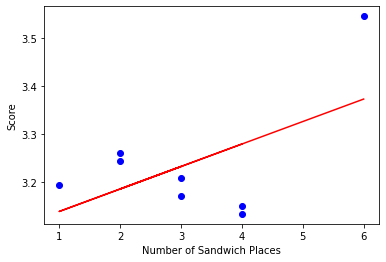

In [76]:
plt.scatter(train.Sandwich_Place, train.Score,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Number of Sandwich Places")
plt.ylabel("Score")

Already, this plotting looks very disappointing. Even selecting the highest correlative variable, there does not seem to be much correlation between the variables.

In [77]:
test_x = np.asanyarray(test[['Sandwich_Place']])
test_y = np.asanyarray(test[['Score']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

Mean absolute error: 0.23
Residual sum of squares (MSE): 0.05
R2-score: -0.59


Testing  for MSE and R2 scores shows that this model cannot predict a city's bicycle score by simply comparing a single venue type and its number of occurences within that city.

#### Multiple Linear Regression

Since simple linear regression yielded a model that was not particularly useful, we next will try multiple linear regression.

In [78]:
list(category_score)

['Bar',
 'Pizza_Place',
 'Coffee_Shop',
 'Sandwich_Place',
 'American_Restaurant',
 'Mexican_Restuarant',
 'Brewery',
 'Hotel',
 'Park',
 'Cafe',
 'Score']

In [79]:
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Bar',
 'Pizza_Place',
 'Coffee_Shop',
 'Sandwich_Place',
 'American_Restaurant',
 'Mexican_Restuarant',
 'Brewery',
 'Hotel',
 'Park',
 'Cafe']])
y = np.asanyarray(train[['Score']])
regr.fit (x, y)
print ('Coefficients: ', regr.coef_)

Coefficients:  [[-0.01670847 -0.01702731  0.01385417  0.06162409 -0.03559916  0.01613618
   0.00883649  0.03146347 -0.01775367 -0.04135364]]


In [80]:
y_hat= regr.predict(test[['Bar',
 'Pizza_Place',
 'Coffee_Shop',
 'Sandwich_Place',
 'American_Restaurant',
 'Mexican_Restuarant',
 'Brewery',
 'Hotel',
 'Park',
 'Cafe']])
x = np.asanyarray(test[['Bar',
 'Pizza_Place',
 'Coffee_Shop',
 'Sandwich_Place',
 'American_Restaurant',
 'Mexican_Restuarant',
 'Brewery',
 'Hotel',
 'Park',
 'Cafe']])
y = np.asanyarray(test[['Score']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 0.12
Variance score: -2.64


While a Variance score of '1' would've indicated a perfectly predictive model, our scores show that multiple linear regression does not provide us with a predictive model.

## Results

The results show that using Foursquare API to create dataframes of venues in ten cities and creating regression models, in the methodology as I have shown, does not result in a predictive model to predict scores for bicycle cities.

## Discussion

While the results may be disappointing, I believe there are a lot of factors that could be addressed and I believe this project still has the capacity to provide valuable insights.

### Limitations and Changes

While some models may be made too powerful through overfitting, I believe this model that I have made suffers from the opposite problem of not having enough data to detect a signal and differentiate it from noise. I will now list some observations and potential changes that could take place in order to make more powerful models in the future using the same data set.
<br>
<br>


*   The sample size that I studied was far too small. While the original dataset from PlacesForBikes contained 557 cities, I only collected data and observed ten of those cities, or a tiny 1.8% of the total cities observed. While it would've been ideal to process the data for all of the cities, I believe that was far beyond the time expectations of this project without the use of a python script to automate the process. While such a script is conceivable and very possible, I believed that it was beyond the scope of the class to design such a script. Further study should yield an interesting demonstration of programming, and with that, much more substantial data to study.
*   My model relied only on data from one source: Foursquare. A much more robust predictive model for cities that are drastically different from one another would likely require data that takes some of these differences into account. More specialized data, such as number of bike trips, trails, weather, and other features would lead some insight into the nature of these cities and what makes them more conducive to bike riding. While I am sure that PlacesForBikes took these factors into account when determining scores for the cities, it would be a much more complicated task to use these features to construct machine learning algorithms that could predict the scores of cities.



## Conclusion

While I was unsuccessful in finding a signal in the data, I believe this project has plenty of potential to either be expanded or retooled to become more powerful and ready to tackle problems similar to the one I observed here. Moving forward, this project also is worthwhile in providing the null hypothesis of the relationship of venue types within a city and how bikeable it is: there is no relationship. Whether that hypothesis could be strengthened or argued against is up to the results of further study.

I have enjoyed working through this project and have learned much in the world of data. I give myself a grade of A+ and a gold star. I hope you too can see the value of the work that I have done here.

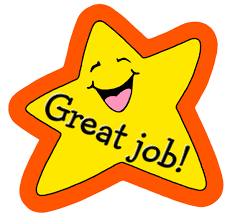

### Plotting (Future Project)

Below are plotting maps for each city. While not directly related to the construction of a regression model, having this data visually presented can provide some interesting insights, such as the shape and layout of the cities. A clustering model of the different venues may provide interesting insights into the segmentation of the city. I have decided to leave these maps here to potentially used in the future should I decide to revisit this project.

#### San Luis Obispo

In [81]:
san_luis_map = folium.Map(location=[35.28263142857143, -120.66234418367347], zoom_start=15)
san_luis_points = san_luis_venues[['lat', 'lng']]

san_luis = san_luis_points.values.tolist()
for point in range(0, len(san_luis)):
  folium.Marker(san_luis[point]).add_to(san_luis_map)
san_luis_map

#### Madison

In [82]:
madison_map = folium.Map(location=[43.04292418483257, -89.40407878799554], zoom_start=15)
madison_points = madison_venues[['lat', 'lng']]

madison = madison_points.values.tolist()
for point in range(0, len(madison)):
  folium.Marker(madison[point]).add_to(madison_map)
madison_map

#### Santa Barbara

In [83]:
santa_barbara_map = folium.Map(location=[34.420073714285714, -119.6975069387755], zoom_start=15)
santa_barbara_points = santa_barbara_venues[['lat', 'lng']]

santa_barbara = santa_barbara_points.values.tolist()
for point in range(0, len(santa_barbara)):
  folium.Marker(santa_barbara[point]).add_to(santa_barbara_map)
santa_barbara_map

#### Washington DC

In [84]:
dc_map = folium.Map(location=[38.8716329, -77.005766], zoom_start=15)
dc_points = dc_venues[['lat', 'lng']]

dc = dc_points.values.tolist()
for point in range(0, len(dc)):
  folium.Marker(dc[point]).add_to(dc_map)
dc_map

#### Missoula

In [85]:
missoula_map = folium.Map(location=[46.874451949999994, -113.99487574026844], zoom_start=15)
missoula_points = missoula_venues[['lat', 'lng']]

missoula = missoula_points.values.tolist()
for point in range(0, len(missoula)):
  folium.Marker(missoula[point]).add_to(missoula_map)
missoula_map

#### Rogers

In [86]:
rogers_map = folium.Map(location=[36.3347994, -94.1193531], zoom_start=15)
rogers_points = rogers_venues[['lat', 'lng']]

rogers = rogers_points.values.tolist()
for point in range(0, len(rogers)):
  folium.Marker(rogers[point]).add_to(rogers_map)
rogers_map

#### Ft. Collins

In [87]:
ft_collins_map = folium.Map(location=[40.5898509, -105.081907325], zoom_start=15)
ft_collins_points = ft_collins_venues[['lat', 'lng']]

ft_collins = ft_collins_points.values.tolist()
for point in range(0, len(ft_collins)):
  folium.Marker(ft_collins[point]).add_to(ft_collins_map)
ft_collins_map

#### Denver

In [88]:
denver_map = folium.Map(location=[39.73918465, -104.99109381315253], zoom_start=15)
denver_points = denver_venues[['lat', 'lng']]

denver = denver_points.values.tolist()
for point in range(0, len(denver)):
  folium.Marker(denver[point]).add_to(denver_map)
denver_map

#### Grand Forks

In [89]:
grand_forks_map = folium.Map(location=[47.9258868, -97.03478493376397], zoom_start=15)
grand_forks_points = grand_forks_venues[['lat', 'lng']]

grand_forks = grand_forks_points.values.tolist()
for point in range(0, len(grand_forks)):
  folium.Marker(grand_forks[point]).add_to(grand_forks_map)
grand_forks_map

#### Fayetteville

In [90]:
fayetteville_map = folium.Map(location=[36.0616665, -94.16113896362981], zoom_start=15)
fayetteville_points = fayetteville_venues[['lat', 'lng']]

fayetteville = fayetteville_points.values.tolist()
for point in range(0, len(fayetteville)):
  folium.Marker(fayetteville[point]).add_to(fayetteville_map)
fayetteville_map